In [1]:
import random
import ast
from sklearn.metrics import classification_report
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series_dataset

/home/wally/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def distance(s, t):
    return (s - t)**2

In [3]:
def DTWDistance2(s, t, w):
    DTW = {}
    w = max(w, abs(len(s) - len(t)))
    for i in range(-1, len(s)):
        for j in range(-1, len(t)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s)):
        for j in range(max(0, i - w), min (len(t), i + w)):
            dist = distance(s[i], t[j])
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])
    return math.sqrt(DTW[len(s) - 1, len(t) - 1])

In [4]:
def DTWDistance(s, t):
    DTW = {}
    for i in range(len(s)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(t)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s)):
        for j in range(len(t)):
            dist = distance(s[i], t[j])
            DTW[(i, j)] = dist + min(DTW[(i - 1, j)], DTW[(i, j - 1)], DTW[(i - 1, j - 1)])
    return math.sqrt(DTW[len(s) - 1, len(t) - 1])

In [5]:
def LBKeogh(s, t, r):
    LBSum = 0
    for ind, i in enumerate(s):
        lowerBound = min((t))
        upperBound = max((t))
        if i > upperBound:
            LBSum = LBSum + (i - upperBound)**2
        elif i < lowerBound:
            LBSum = LBSum + (i - lowerBound)**2
    return math.sqrt(LBSum)

In [6]:
def knn(train, test, w):
    preds = []
    for ind, i in enumerate(test):
        minDist = float('inf')
        closestSeq = []
        for j in train:
            if LBKeogh(i[:-1], j[:-1], 5) < minDist:
                dist = DTWDistance(i[:-1], j[:-1], w)
                if dist < minDist:
                    minDist = dist
                    closestSeq = j;
        preds.append(closestSeq[-1])
    return classification_report(test[:, -1], preds)

In [7]:
def Kmeans(data, centroids, clusters, iteractions, w = 5):
    counter = 0
    for n in range(iteractions):
        counter += 1
        print(counter)
        assignments = {}
        for ind, i in enumerate(data):
            minDist = float('inf')
            closestClust = None
            for key in centroids:
                if LBKeogh(i, centroids[key], 5) < minDist:
                    curDist = DTWDistance(i, centroids[key])
                    if curDist < minDist:
                        minDist = curDist
                        closestClust = key
            if closestClust in assignments:
                assignments[closestClust].append(ind)
            else:
                assignments[closestClust] = []        
    return assignments

In [8]:
biggerLinks = {}
smallestLinks = {}
sz = 10000
with open("/home/wally/eclipse-workspace/pkmeansimulator/output/sequences/10-biggerSequences-with-link-interval-2020-06-04T11:59:59.507123.csv","r") as f:
    for i in f.readlines():
        l = list(map(str, i.split(';')))
        biggerLinks[l[0]] = int(l[1])
with open("/home/wally/eclipse-workspace/pkmeansimulator/output/sequences/10-smallestSequences-with-link-interval-2020-06-04T11:59:59.507123.csv","r") as f:
    for i in f.readlines():
        l = list(map(str, i.split(';')))
        smallestLinks[l[0]] = int(l[1])
        if (sz > int(l[1])):
            sz = int(l[1])
print(biggerLinks)
print(smallestLinks)
print(sz)

{'298786464-79200-82800': 501, '327005892-79200-82800': 503, '221553428-79200-82800': 521, '298786469-79200-82800': 523, '688769623-0-3600': 529, '298786465-79200-82800': 557, '298786467-79200-82800': 560, '298786468-79200-82800': 561, '298786466-79200-82800': 566, '152980843-0-3600': 743}
{'152746500-82800-86400': 2, '420135389-82800-86400': 2, '301677886-82800-86400': 2, '547531535-82800-86400': 2, '547531525-82800-86400': 2, '103934334-82800-86400': 2, '301677885-82800-86400': 2, '634307497-82800-86400': 2, '157490277-82800-86400': 2, '8838069-82800-86400': 2}
2


In [9]:
links = {}
type(links)

dict

In [10]:
def chartFirst(links,file, size, df):
    name = file.split("-")
    print(name[0]+"-"+name[1])
    l = df['link'].value_counts().head(size).index.tolist()
    print(df['link'].value_counts().head(size))
    links[name[0]+"-"+name[1]] = l
    print(l)

In [11]:
def chartLast(size, df):
    df = df['link'].value_counts()
    df.tail(size).plot(kind = 'bar')
    plt.show()

In [12]:
def chartFirst(size, df):
    df = df['link'].value_counts()
    df.head(size).plot(kind = 'bar')
    plt.show()

In [13]:
bigger_accessed_sequence = {}
smallest_accessed_sequence = {}
links_id = list()
links_interval = list()
'''
for link_id in biggerLinks:
    links_id.append(link_id.split('-')[0])
    links_interval.append(link_id.split('-')[1]+'-'+link_id.split('-')[2])
'''
for link_id in smallestLinks:
    links_id.append(link_id.split('-')[0])
    links_interval.append(link_id.split('-')[1]+'-'+link_id.split('-')[2])

print(links_id)
print(links_interval)

['152746500', '420135389', '301677886', '547531535', '547531525', '103934334', '301677885', '634307497', '157490277', '8838069']
['82800-86400', '82800-86400', '82800-86400', '82800-86400', '82800-86400', '82800-86400', '82800-86400', '82800-86400', '82800-86400', '82800-86400']


In [14]:
data = []
most_accessed_sequence = {}
with open("/home/wally/eclipse-workspace/pkmeansimulator/output/sequences/with-link-interval-2020-06-04T12:11:35.643643.csv","r") as f:
    for i in f.readlines():
        l = list(map(int, i.split(';')))
        if str(l[0]) in links_id and str(l[1])+'-'+str(l[2]) in links_interval:
            most_accessed_sequence[str(l[0])+'-'+str(l[1])+'-'+str(l[2])] = l[3:]
        else:
            data.append(l)
print(len(most_accessed_sequence))
print(len(data))

10
5464


In [15]:
def chartLinks(sz, link, data, link_interval):
    for xx in data:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(link.ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Link %s' % link_interval,
             transform=plt.gca().transAxes)
    plt.title(link_interval)
    plt.tight_layout()
    plt.show()

In [16]:
def chartLink(link, link_interval):
    plt.plot(link.ravel(), "r-")
    plt.xlim(0, len(link))
    plt.ylim(link[0], link[len(link)-1])
    plt.text(0.55, 0.85,'Link %s' % link_interval,
             transform=plt.gca().transAxes)
    plt.title(link_interval)
    plt.tight_layout()
    plt.show()

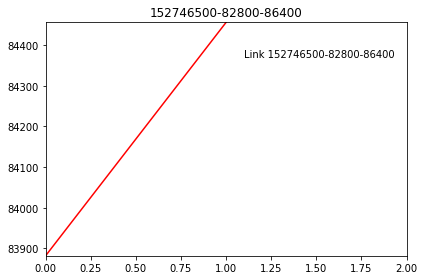

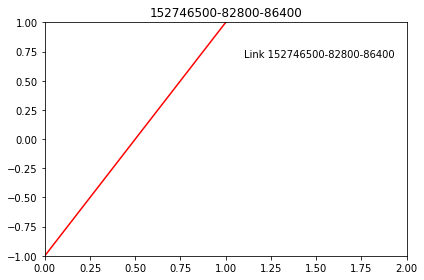

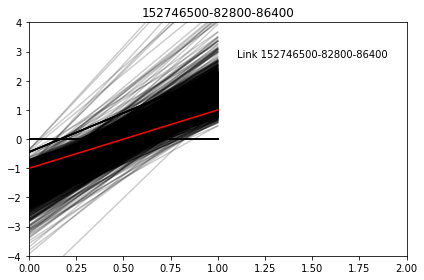

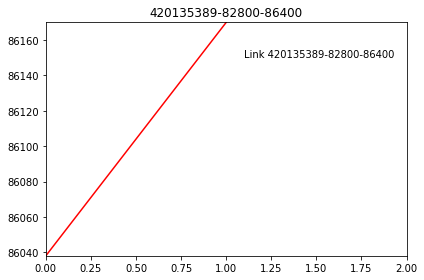

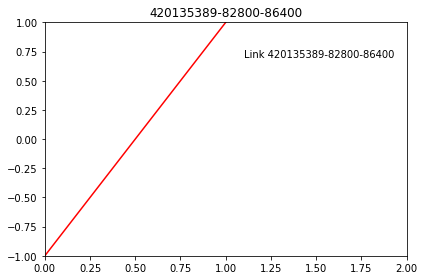

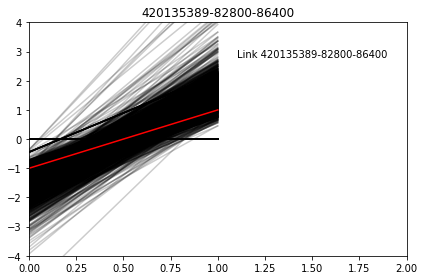

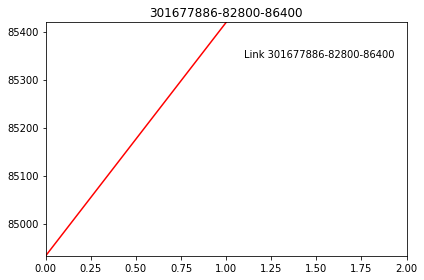

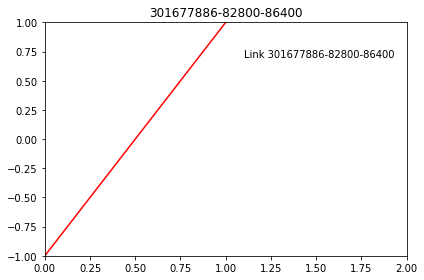

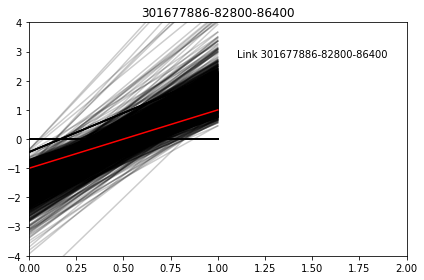

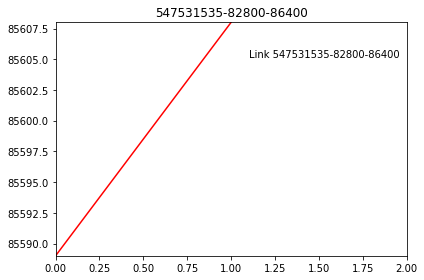

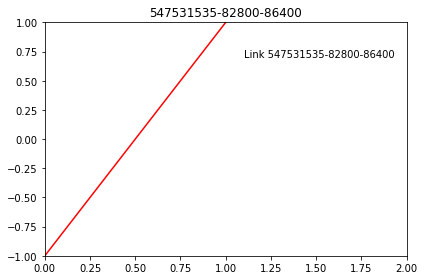

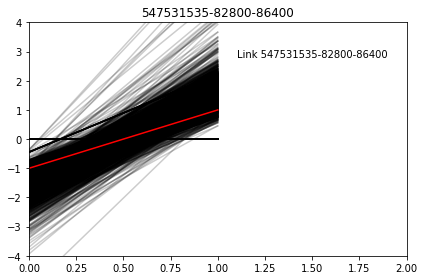

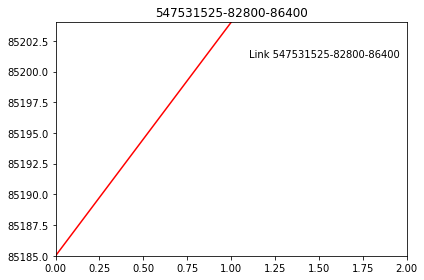

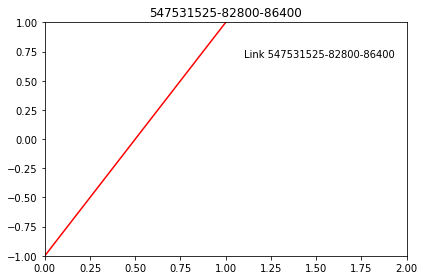

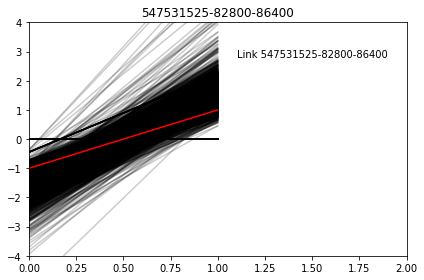

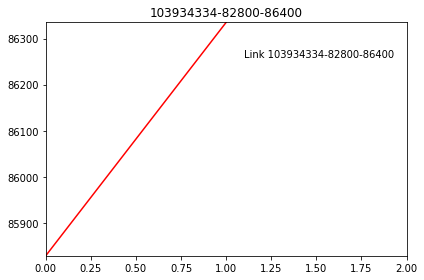

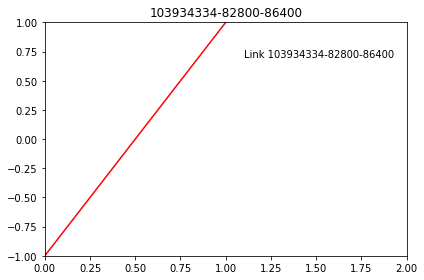

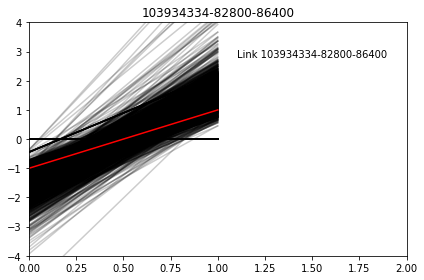

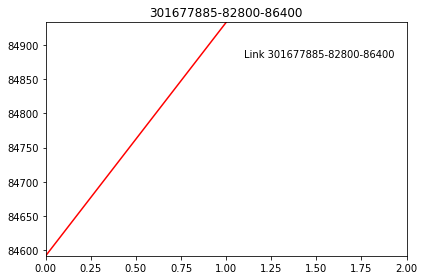

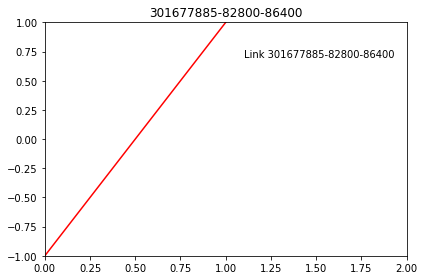

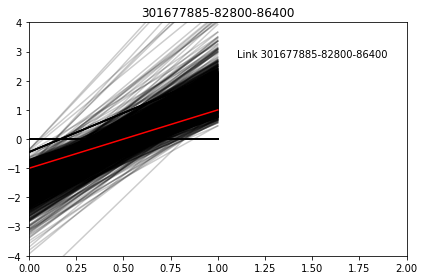

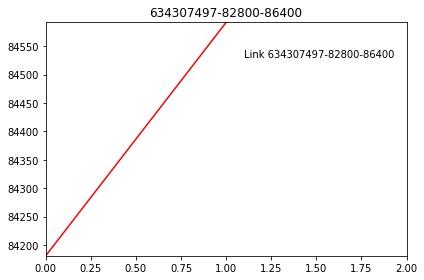

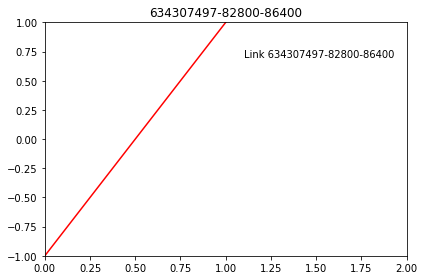

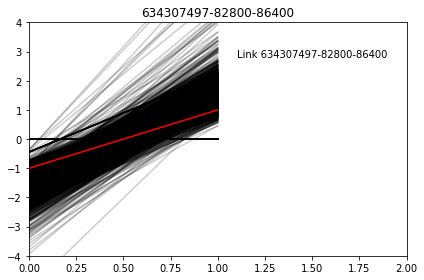

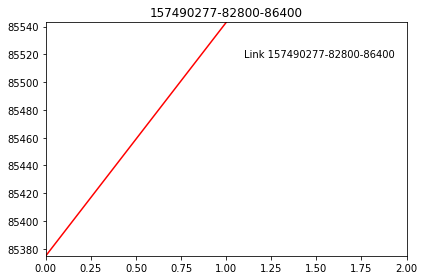

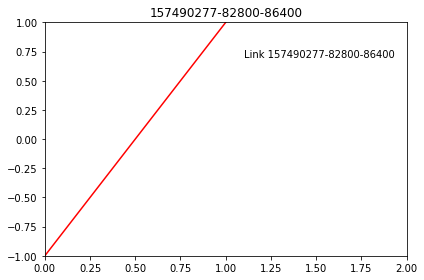

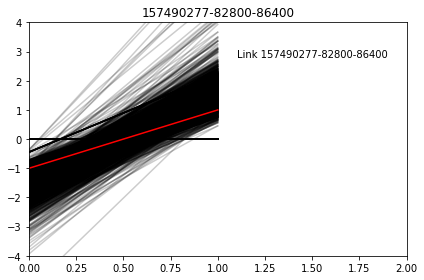

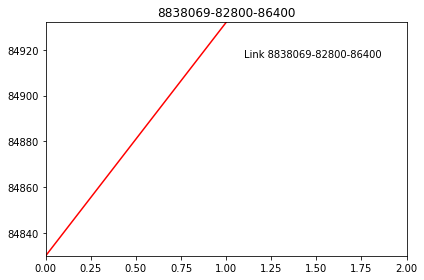

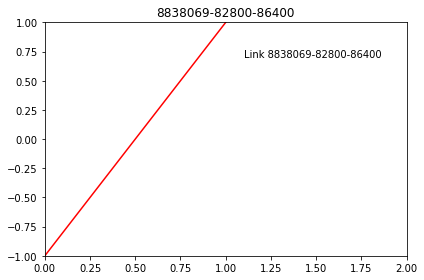

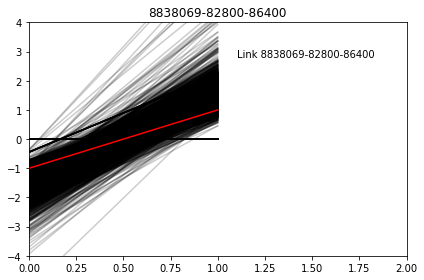

In [17]:
centroids = {}
general_data = list()
for key in most_accessed_sequence:
    sequence = most_accessed_sequence[key]
    X = to_time_series_dataset(sequence)
    chartLink(X[0], key)
    X = TimeSeriesScalerMeanVariance().fit_transform(X)
    chartLink(X[0], key)
    X = TimeSeriesResampler(sz).fit_transform(X)
    links_data = list()
    centroids[key] = X[0]
    for other in data:
        Y = to_time_series_dataset(other[3:])
        Y = TimeSeriesScalerMeanVariance().fit_transform(Y)
        Y = TimeSeriesResampler(sz).fit_transform(Y)
        links_data.append(Y[0])
        general_data.append(Y[0])
    chartLinks(sz, X[0], links_data, key)

In [18]:
result = Kmeans(general_data, centroids, len(centroids), 1, w = 5)

1


In [19]:
print(result)

{'152746500-82800-86400': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 2

152746500-82800-86400


KeyboardInterrupt: 

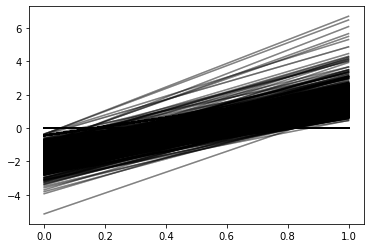

In [20]:
for key in result:
    centroid = centroids[key]
    data_cluster = list()
    print(key)
    links_sequences_pos = list()
    for i in result[key]:
        if not i in links_sequences_pos:
            links_sequences_pos.append(i)
            data_cluster.append(general_data[i])
    chartLinks(sz, centroid, data_cluster, key)
    